In [1]:
# !pip uninstall -y numpy
# !pip install numpy==1.23.5

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.1.3

!pip uninstall -y keras
!pip install keras==2.12.0
!pip uninstall -y tensorflow
!pip install tensorflow==2.12.0

#install pandas-ta and pulp
#install pandas-ta and pulp using pip.
!pip install pandas-ta
!pip install pulp


import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas_ta as ta
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpInteger

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Model,Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Activation, Bidirectional, LayerNormalization,Conv1D, MaxPooling1D, Flatten,BatchNormalization,GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam,SGD
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import MeanSquaredError
import warnings
warnings.filterwarnings('ignore')


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/spinners.py", li

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=b406d6b2fd8195902a74a26447283a2cfc775b8a71bd85095a3e22214d308549
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 100.5 MB/s eta 0:00:00


In [9]:
class LSTMTrader:
    def __init__(self, ticker, backcandles=60,days=10):
        self.ticker = ticker
        self.backcandles = backcandles
        self.days=days
        self.modelLSTM = None
        self.modelCNNLSTM=None
        self.scaler = MinMaxScaler()
        self.data = None
        self.X, self.y = None, None
        self.X_train, self.X_test = None, None
        self.y_train, self.y_test = None, None

    def download_and_prepare_data(self):
        import time
        data = yf.Ticker(self.ticker).history(start="2015-01-01")
        data['RSI']=ta.rsi(data.Close, length=15)
        data['EMAF']=ta.ema(data.Close, length=20)
        data['EMAM']=ta.ema(data.Close, length=100)
        data['EMAS']=ta.ema(data.Close, length=150)

        data['Target'] = data['Close']-data.Open

        data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

        data['TargetNextClose'] = data['Close'].shift(-1)

        data.dropna(inplace=True)
        data.reset_index(inplace = True)

        self.raw_open = data['Open'].values
        self.raw_close = data['Close'].values
        data.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume','Stock Splits','Dividends','Stock Name'], axis=1, inplace=True, errors='ignore')
        self.data = data



    def scale_and_create_sequences(self):
        data_scaled = self.scaler.fit_transform(self.data)
        X, y = [], []
        num_features = data_scaled.shape[1]
        for j in range(num_features):
            X.append([])
            for i in range(len(data_scaled)):
                if i < self.backcandles:
                    padding = np.zeros((self.backcandles - i,))
                    seq = np.concatenate((padding, data_scaled[:i, j]))
                else:
                    seq = data_scaled[i - self.backcandles:i, j]
                X[j].append(seq)
        X = np.moveaxis(X, [0], [2])
        self.X = np.array(X)
        target_col_index = self.data.columns.get_loc("Target")
        print(target_col_index)
        self.y = data_scaled[:, target_col_index].reshape(-1, 1)
        split = int(len(self.X) * 0.8)
        self.X_train, self.X_test = self.X[:split], self.X[split:]
        self.y_train, self.y_test = self.y[:split], self.y[split:]


    def build_model(self):
        lstm_input = Input(shape=(self.backcandles, self.X.shape[2]), name='lstm_input')
        inputs = LSTM(150, name='first_layer')(lstm_input)
        inputs = Dense(1, name='dense_layer')(inputs)
        output = Activation('linear', name='output')(inputs)
        model = Model(inputs=lstm_input, outputs=output)
        adam = Adam()
        model.compile(optimizer=adam, loss='mse')
        self.modelLSTM = Model(lstm_input, output)
        self.modelLSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    def trainLSTM(self):
        self.modelLSTM.summary()
        self.modelLSTM.fit(self.X_train, self.y_train,
                      validation_split=0.1,
                      epochs=1,
                      batch_size=32,
                      verbose=1)
    def build_cnn_lstm_model(self):
      model = Sequential()

      model.add(
          Conv1D(
              32,
              100,
              padding="same",
              activation="tanh",
              input_shape=(self.backcandles, self.X.shape[2]),
          )
      )
      model.add(MaxPooling1D(1,padding="same"))

      model.add(LSTM(150))
      model.add(Dense(1))
      model.add(Activation('linear',name='output'))

      model.compile(
          optimizer=Adam(learning_rate=0.001),
          loss="mse",
      )

      self.modelCNNLSTM=model

    def trainCNNLSTM(self):
      # self.modelCNNLSTM.summary()
      self.modelCNNLSTM.summary()
      self.modelCNNLSTM.fit(
          self.X_train, self.y_train,
          validation_split=0.1,
          epochs=100,
          batch_size=32,
          verbose=1
      )

    def evaluate_model_metrics(self, model, model_name="Model"):
      y_train_pred = model.predict(self.X_train)
      y_test_pred = model.predict(self.X_test)

      target_col_index = self.data.columns.get_loc("Target")
      def inverse_scaled(y_scaled):
          padded = np.zeros((y_scaled.shape[0], self.X.shape[2]))
          padded[:, target_col_index] = y_scaled.flatten()
          return self.scaler.inverse_transform(padded)[:, target_col_index]


      y_train_true = inverse_scaled(self.y_train)
      y_train_pred = inverse_scaled(y_train_pred)

      y_test_true = inverse_scaled(self.y_test)
      y_test_pred = inverse_scaled(y_test_pred)

      def compute_metrics(y_true, y_pred):
          mae = mean_absolute_error(y_true, y_pred)
          rmse = np.sqrt(mean_squared_error(y_true, y_pred))
          r2 = r2_score(y_true, y_pred)
          return mae, rmse, r2

      train_metrics = compute_metrics(y_train_true, y_train_pred)
      test_metrics = compute_metrics(y_test_true, y_test_pred)

      print(f"\n{model_name} Train Metrics:")
      print(f"MAE: {train_metrics[0]:.4f} | RMSE: {train_metrics[1]:.4f} | R²: {train_metrics[2]:.4f}")

      print(f"\n{model_name} Test Metrics:")
      print(f"MAE: {test_metrics[0]:.4f} | RMSE: {test_metrics[1]:.4f} | R²: {test_metrics[2]:.4f}")

      return train_metrics, test_metrics
    def compare_models(self):
      print("\n🔵 Training LSTM Model...")
      self.build_model()
      self.trainLSTM()
      lstm_train, lstm_test = self.evaluate_model_metrics(self.modelLSTM, model_name="LSTM")

      print("\n🟢 Training CNN Model...")
      self.build_cnn_lstm_model()
      self.trainCNNLSTM()
      cnn_train, cnn_test = self.evaluate_model_metrics(self.modelCNNLSTM, model_name="CNN")

      # Padding helper for inverse scaling
      target_col_index = self.data.columns.get_loc("Target")
      def inverse_scaled(y_scaled):
        padded = np.zeros((y_scaled.shape[0], self.X.shape[2]))
        padded[:, target_col_index] = y_scaled.flatten()
        return self.scaler.inverse_transform(padded)[:, target_col_index]
      # Predict for both models
      y_true = inverse_scaled(self.y_test)
      y_pred_lstm = inverse_scaled(self.modelLSTM.predict(self.X_test))
      y_pred_cnn = inverse_scaled(self.modelCNNLSTM.predict(self.X_test))
      open_test = self.raw_open[-len(self.y_test):]  # Align length

      # Reconstruct closes
      actual_close = open_test + y_true
      pred_close_lstm = open_test + y_pred_lstm
      pred_close_cnn = open_test + y_pred_cnn
      plt.figure(figsize=(10, 5))
      plt.plot(y_true, label="Actual Δ (Close - Open)", color='blue')
      plt.plot(y_pred_lstm, label="Predicted Δ (LSTM)", color='green', linestyle='--')
      plt.title("Actual vs Predicted Δ (Close - Open) - LSTM")
      plt.xlabel("Samples")
      plt.ylabel("Delta")
      plt.legend()
      plt.grid(True)
      plt.savefig("LSTM_target_delta.png", dpi=300)
      plt.show()


      plt.figure(figsize=(10, 5))
      plt.plot(actual_close, label="Actual Close", color='blue')
      plt.plot(pred_close_lstm, label="Predicted Close (LSTM)", color='green', linestyle='--')
      plt.title("Actual vs Predicted Close Price - LSTM")
      plt.xlabel("Samples")
      plt.ylabel("Close Price")
      plt.legend()
      plt.grid(True)
      plt.savefig("LSTM_predicted_close.png", dpi=300)
      plt.show()



      plt.figure(figsize=(10, 5))
      plt.plot(y_true, label="Actual Δ (Close - Open)", color='blue')
      plt.plot(y_pred_cnn, label="Predicted Δ (CNN)", color='orange', linestyle='--')
      plt.title("Actual vs Predicted Δ (Close - Open) - CNN")
      plt.xlabel("Samples")
      plt.ylabel("Delta")
      plt.legend()
      plt.grid(True)
      plt.savefig("CNN_target_delta.png", dpi=300)
      plt.show()

      plt.figure(figsize=(10, 5))
      plt.plot(actual_close, label="Actual Close", color='blue')
      plt.plot(pred_close_cnn, label="Predicted Close (CNN)", color='orange', linestyle='--')
      plt.title("Actual vs Predicted Close Price - CNN")
      plt.xlabel("Samples")
      plt.ylabel("Close Price")
      plt.legend()
      plt.grid(True)
      plt.savefig("CNN_predicted_close.png", dpi=300)
      plt.show()




    def predict_next_days(self):
      target_index = self.data.columns.get_loc("Target")
      last_seq = self.X_test[-1:]
      preds = []
      opens = self.raw_open[-self.days:]
      seq = last_seq.copy()

      for i in range(self.days):
          pred_scaled = self.modelLSTM.predict(seq)

          # Inverse transform
          pad = np.zeros((1, self.X.shape[2]))
          pad[0, target_index] = pred_scaled[0, 0]
          delta_unscaled = self.scaler.inverse_transform(pad)[0, target_index]

          # Predict Close = Open + delta
          preds.append(opens[i] + delta_unscaled)

          # Create next input row (simulate)
          new_row = self.data.iloc[-1].copy()
          new_row['Target'] = pred_scaled[0, 0]

          last_row_scaled = self.scaler.transform([new_row])[0]
          new_seq = last_row_scaled.reshape(1, 1, -1)
          seq = np.concatenate((seq[:, 1:, :], new_seq), axis=1)

      return preds


    def run_full_pipeline(self):

        print(f"Running pipeline for {self.ticker}")
        self.download_and_prepare_data()

        self.scale_and_create_sequences()
        self.compare_models()
        preds = self.predict_next_days()
        return preds

In [4]:

def get_best_trade_opportunities(predictions):
    trades = []

    for stock, prices in predictions.items():
        max_profit = 0
        buy_day = sell_day = 0
        min_price = prices[0]

        for i in range(1, len(prices)):
            if prices[i] - min_price > max_profit:
                max_profit = prices[i] - min_price
                sell_day = i
                buy_day = prices.index(min_price)
            if prices[i] < min_price:
                min_price = prices[i]

        trades.append({
            'name': stock,
            'buy_day': buy_day,
            'sell_day': sell_day,
            'buy_price': float(prices[buy_day]),
            'sell_price': float(prices[sell_day]),
            'profit_per_share': float(prices[sell_day] - prices[buy_day])
        })

    return trades

def optimize_trades_with_ilp(predictions, budget, top_n=None):
    # Step 1: Get trade opportunities
    trades = get_best_trade_opportunities(predictions)

    # Optionally limit to top-N most profitable stocks
    if top_n:
        trades.sort(key=lambda x: x['profit_per_share'], reverse=True)
        trades = trades[:top_n]

    # Step 2: Set up ILP model
    model = LpProblem(name="stock-allocation", sense=LpMaximize)

    # Variables
    x_vars = {t['name']: LpVariable(f"x_{t['name']}", lowBound=0, cat=LpInteger) for t in trades}

    # Objective: Maximize profit
    model += lpSum(t['profit_per_share'] * x_vars[t['name']] for t in trades)

    # Constraint: Don't exceed budget
    model += lpSum(t['buy_price'] * x_vars[t['name']] for t in trades) <= budget

    # Solve
    model.solve()

    # Step 3: Prepare result
    plan = []
    for t in trades:
        shares = int(x_vars[t['name']].value())
        if shares > 0:
            invested = shares * t['buy_price']
            expected_return = shares * t['sell_price']
            plan.append({
                'stock': t['name'],
                'buy_day': t['buy_day'],
                'sell_day': t['sell_day'],
                'buy_price': round(t['buy_price'], 2),
                'sell_price': round(t['sell_price'], 2),
                'shares': shares,
                'invested': round(invested, 2),
                'expected_return': round(expected_return, 2),
                'profit': round(expected_return - invested, 2)
            })

    total_invested = sum(p['invested'] for p in plan)
    total_profit = sum(p['profit'] for p in plan)

    return plan, round(total_invested, 2), round(total_profit, 2)



In [5]:
def get_exact_date(day_number):
    today = datetime.today()
    target_date = today + timedelta(days=day_number - 1)  # Day 1 is today
    return target_date.strftime("%A, %B %d, %Y")  # Format: Day, Month Date, Year

Enter backcandles period in days (default: 45): 
Enter prediction horizon in days (default: 10): 
Enter investment amount in dollars: 10000
Running pipeline for AAPL
           Close        RSI        EMAF        EMAM        EMAS    Target  \
0      25.902020  30.846363   27.330333   27.840804   27.764528 -0.188985   
1      25.989758  32.188161   27.202660   27.804149   27.741021  0.211481   
2      26.934681  44.593409   27.177138   27.786932   27.730341  0.717689   
3      25.533049  34.548790   27.020558   27.742301   27.701238 -0.971916   
4      25.926765  38.704134   26.916387   27.706350   27.677735  0.609697   
...          ...        ...         ...         ...         ...       ...   
2462  202.089996  45.352930  206.173109  216.367933  218.191105 -3.080002   
2463  201.360001  44.691499  205.714718  216.070746  217.968176  0.649994   
2464  195.270004  39.537455  204.719983  215.658850  217.667538  1.600006   
2465  200.210007  45.045527  204.290462  215.352932  217.436312 

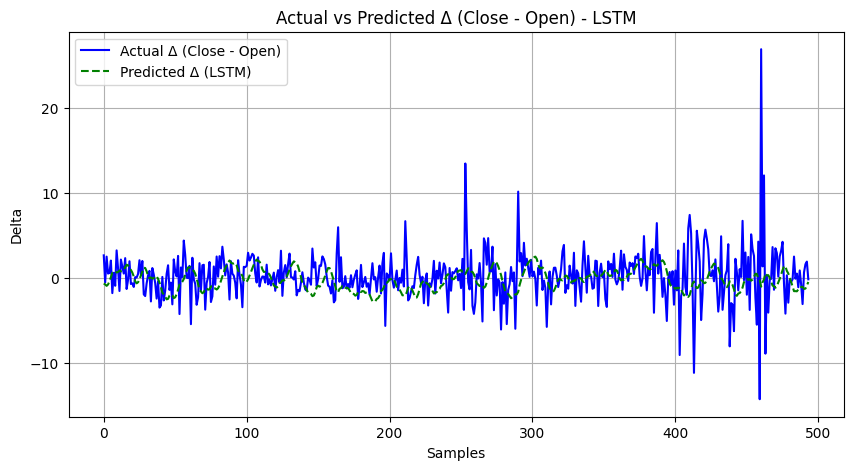

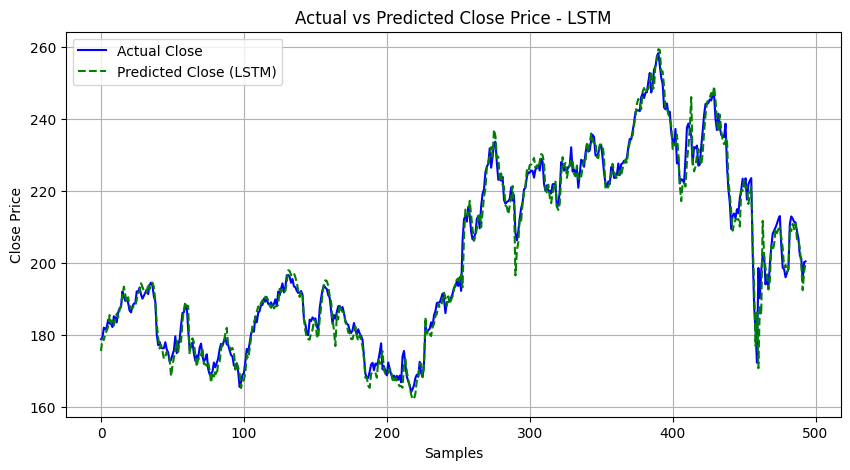

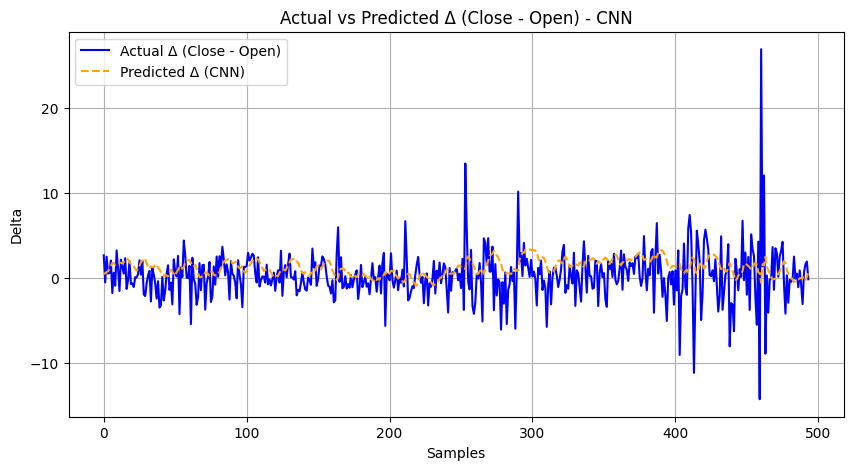

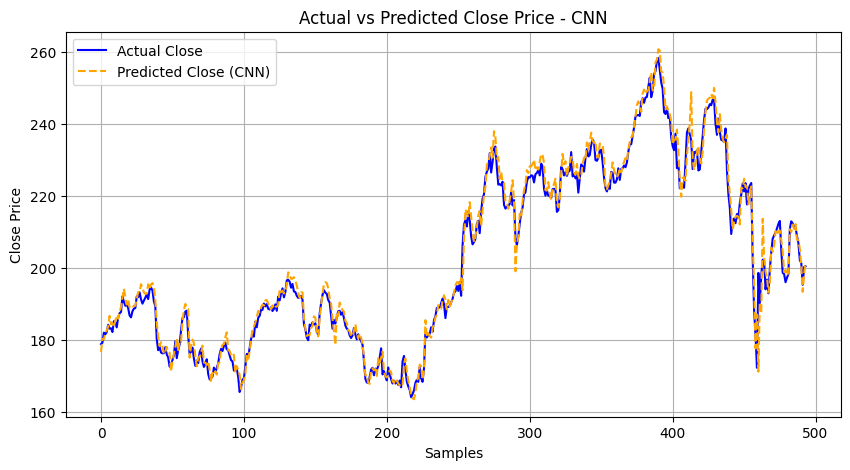

1/1 [==============================] - 0s 34ms/step
Running pipeline for MSFT
           Close        RSI        EMAF        EMAM        EMAS    Target  \
0      40.423771  53.530969   40.185454   39.197693   38.650184 -0.945129   
1      40.527809  54.420235   40.218059   39.224032   38.675054  0.303484   
2      41.039394  58.594802   40.296282   39.259980   38.706369  0.329495   
3      40.241676  50.818769   40.291081   39.279419   38.726705 -0.355507   
4      40.527809  53.205352   40.313627   39.304140   38.750560  0.476902   
...          ...        ...         ...         ...         ...       ...   
2462  452.570007  70.640188  433.368601  410.129255  410.382372 -2.000000   
2463  454.859985  71.585095  435.415399  411.015012  410.971479 -0.090027   
2464  450.179993  66.872498  436.821551  411.790556  411.490797  0.199982   
2465  460.690002  71.402397  439.094737  412.758862  412.142443  4.209991   
2466  457.359985  68.234923  440.834284  413.642053  412.741350 -3.860016  

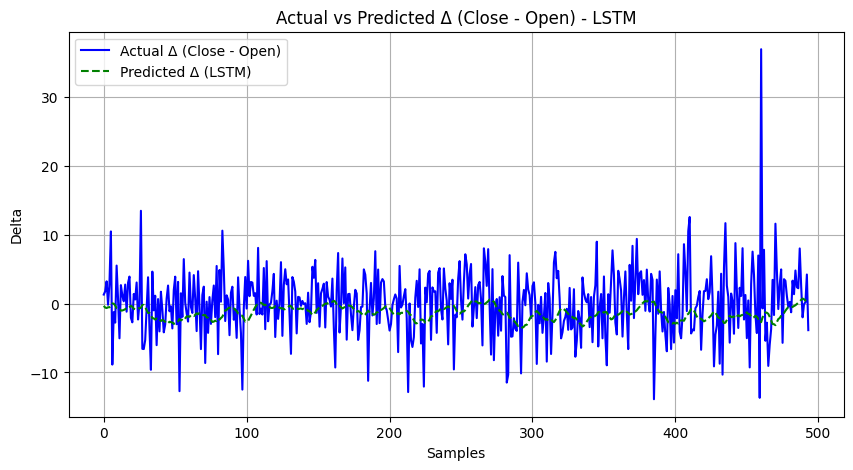

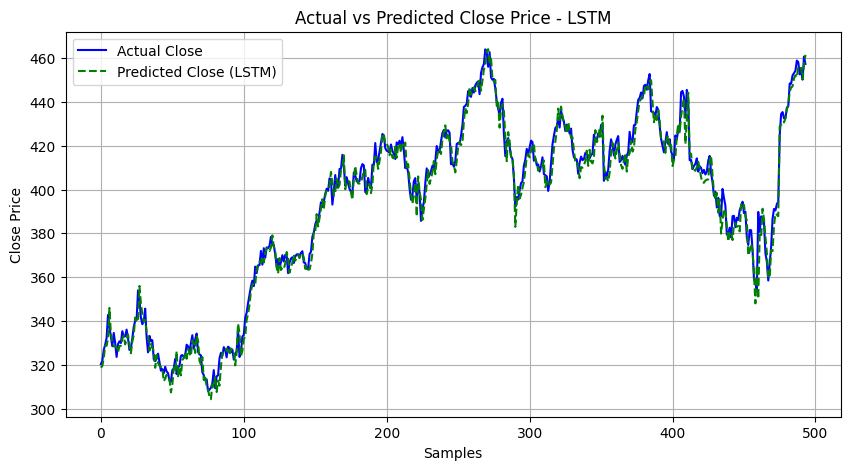

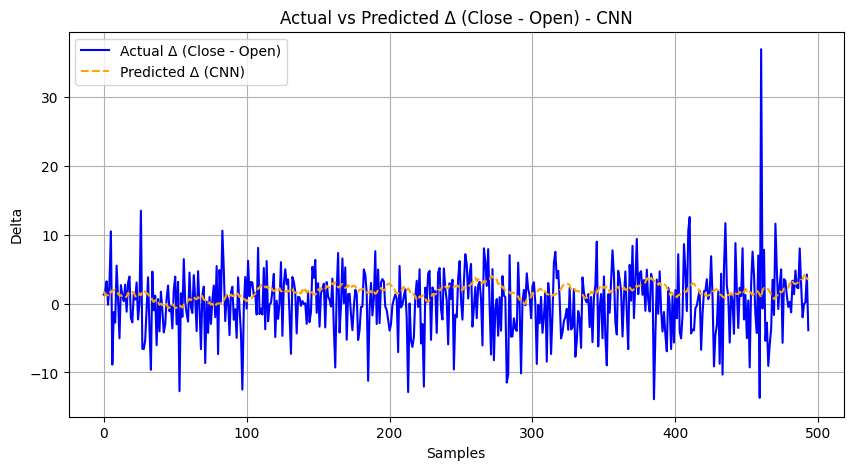

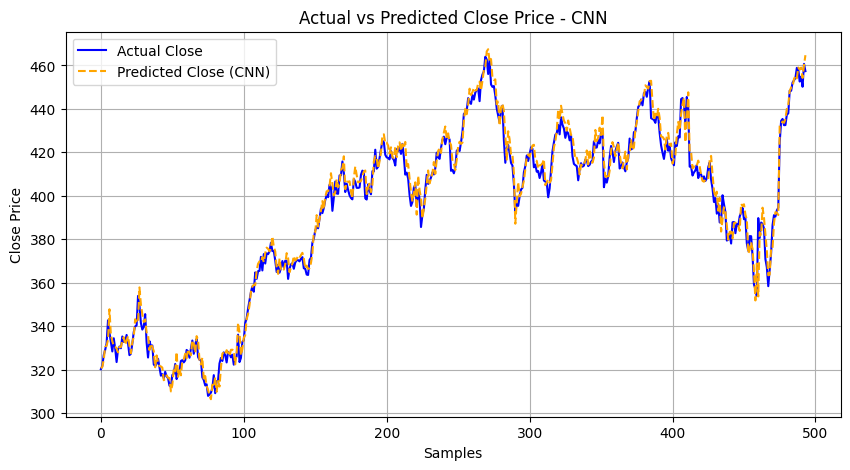

1/1 [==============================] - 0s 27ms/step
Running pipeline for NVDA
           Close        RSI        EMAF        EMAM        EMAS    Target  \
0       0.494949  54.112028    0.486622    0.503457    0.511506 -0.001936   
1       0.556182  75.088011    0.493247    0.504501    0.512098  0.012586   
2       0.575545  78.428685    0.501085    0.505908    0.512938  0.023235   
3       0.572640  76.773947    0.507899    0.507229    0.513729  0.005567   
4       0.574092  77.033517    0.514204    0.508553    0.514528  0.010649   
...          ...        ...         ...         ...         ...       ...   
2462  131.800003  65.024388  123.282276  120.531048  120.631582 -1.259995   
2463  132.830002  65.953400  124.191583  120.774592  120.793151  0.600006   
2464  131.289993  63.261581  124.867622  120.982818  120.932182  1.289993   
2465  135.500000  67.184511  125.880230  121.270287  121.125133  1.350006   
2466  134.809998  65.947930  126.730684  121.538400  121.306390 -1.220001  

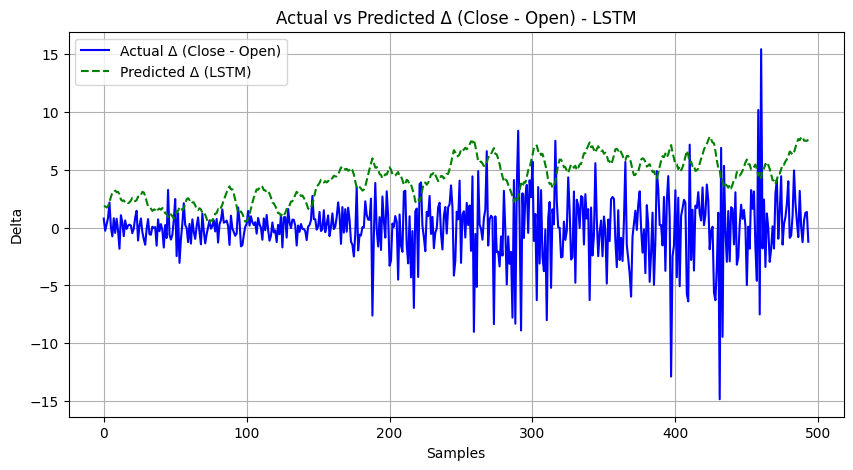

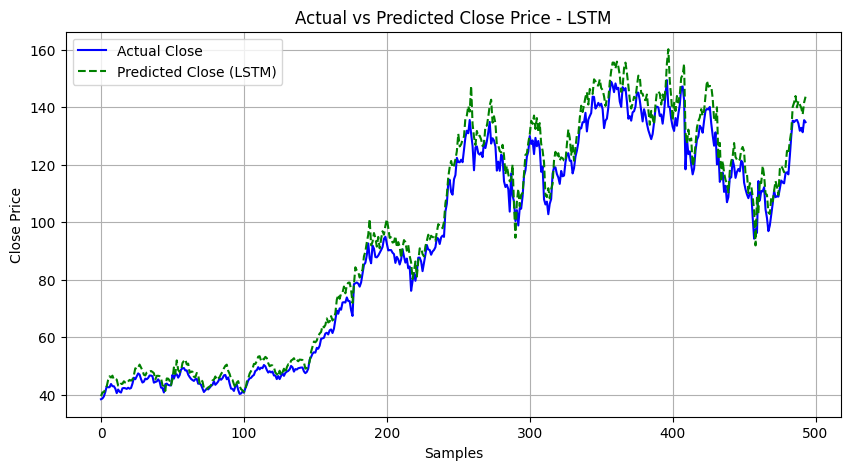

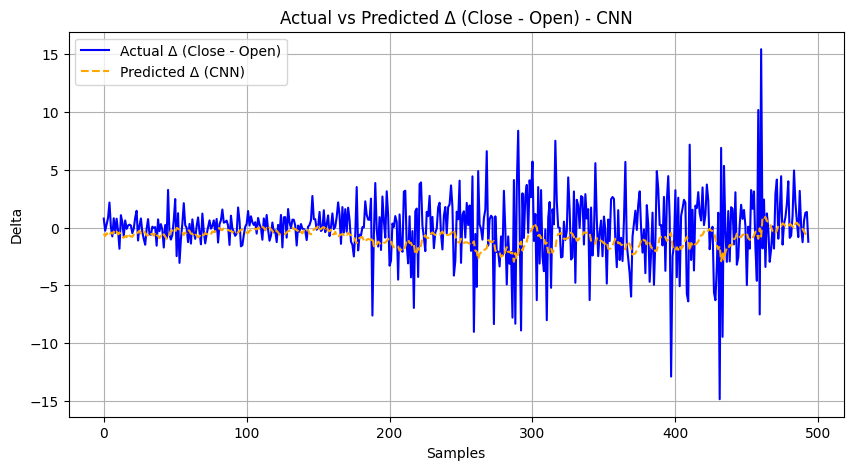

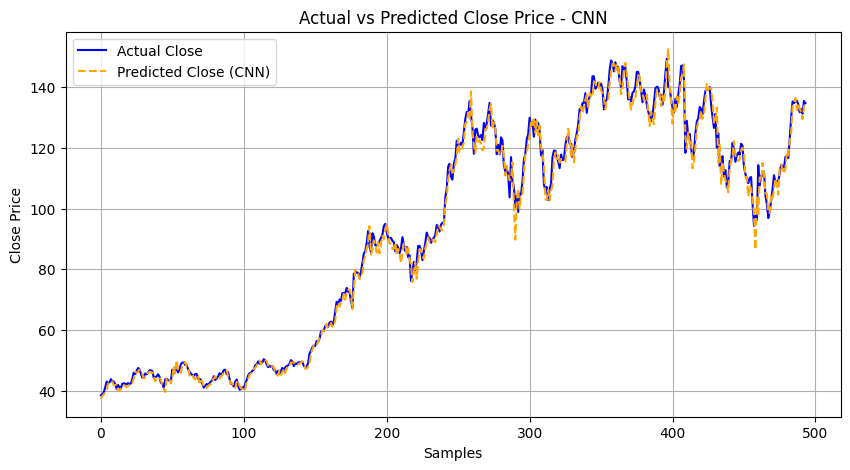

1/1 [==============================] - 0s 25ms/step
Running pipeline for AMZN
           Close        RSI        EMAF        EMAM        EMAS    Target  \
0      26.473000  71.107443   25.314115   21.774691   20.150130 -0.492001   
1      26.131001  65.885037   25.391914   21.860954   20.229347 -0.327000   
2      26.200001  66.418186   25.468875   21.946876   20.308428 -0.226000   
3      26.372999  67.771201   25.554982   22.034522   20.388754  0.190498   
4      26.295500  66.485487   25.625507   22.118898   20.466989  0.108000   
...          ...        ...         ...         ...         ...       ...   
2462  201.119995  55.448999  197.374875  199.579006  199.494994 -0.490005   
2463  203.100006  57.122854  197.920126  199.648729  199.542743  1.720001   
2464  200.990005  54.773186  198.212495  199.675289  199.561912  2.090012   
2465  206.020004  59.073048  198.956068  199.800927  199.647449  2.930008   
2466  204.720001  57.557736  199.505014  199.898334  199.714635 -1.199997  

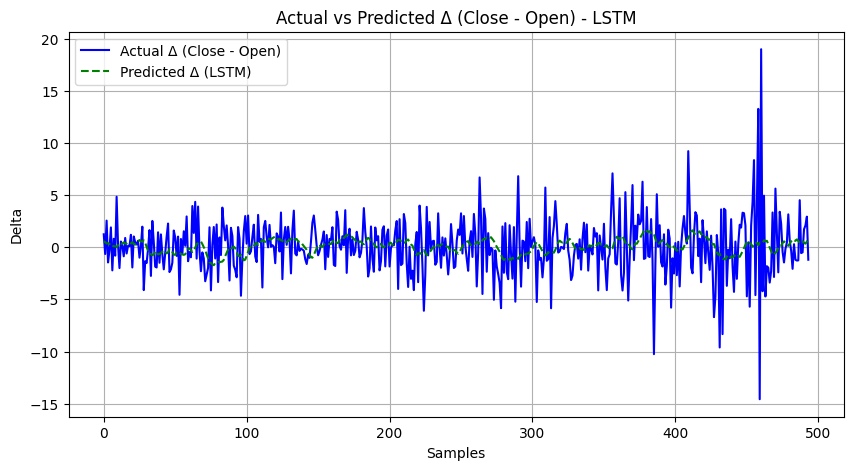

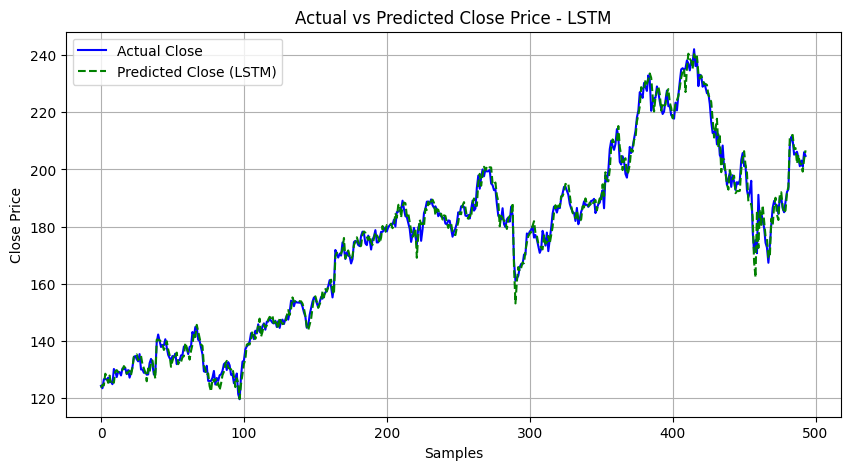

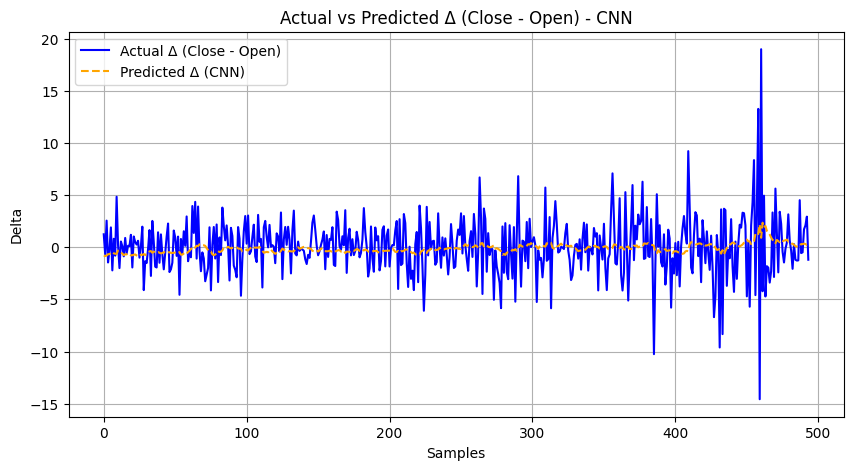

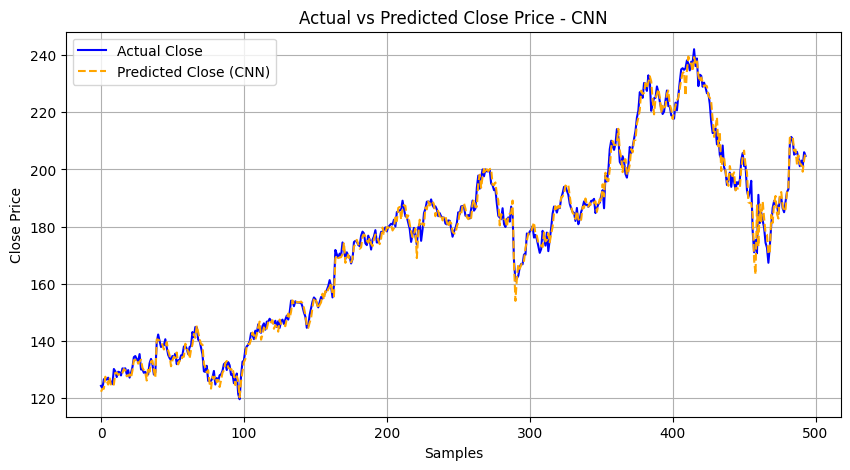

1/1 [==============================] - 0s 31ms/step
Running pipeline for GOOGL
           Close        RSI        EMAF        EMAM        EMAS    Target  \
0      33.348064  66.388373   32.091067   28.929463   27.837653 -0.191088   
1      33.061436  63.400122   32.183483   29.011284   27.906842 -0.168692   
2      32.999233  62.743456   32.261173   29.090253   27.974291 -0.196559   
3      34.350769  69.981572   32.460182   29.194422   28.058748 -0.461793   
4      34.408997  70.248379   32.645784   29.297681   28.142857 -0.150279   
...          ...        ...         ...         ...         ...       ...   
2462  168.559998  58.770848  161.488757  166.927480  168.294794  4.869995   
2463  170.869995  60.878017  162.382209  167.005550  168.328903 -0.980011   
2464  168.470001  57.600941  162.961998  167.034549  168.330771 -0.589996   
2465  172.899994  61.680404  163.908474  167.150696  168.391291  2.739990   
2466  172.360001  60.914950  164.713381  167.253851  168.443857 -0.800003 

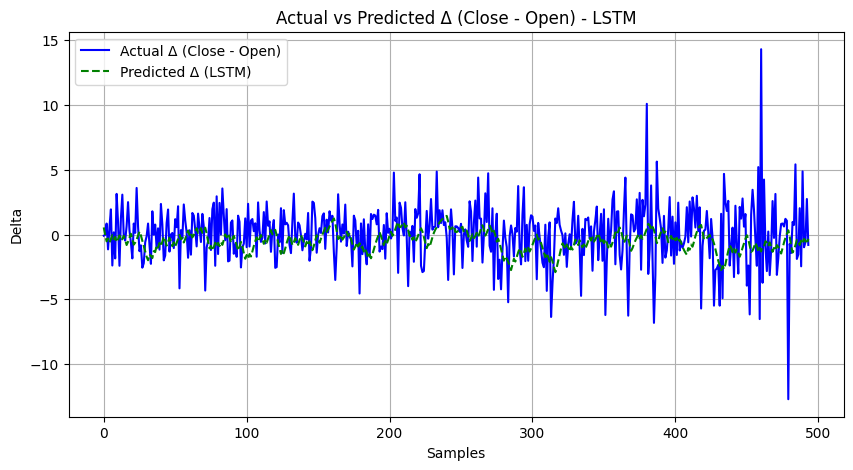

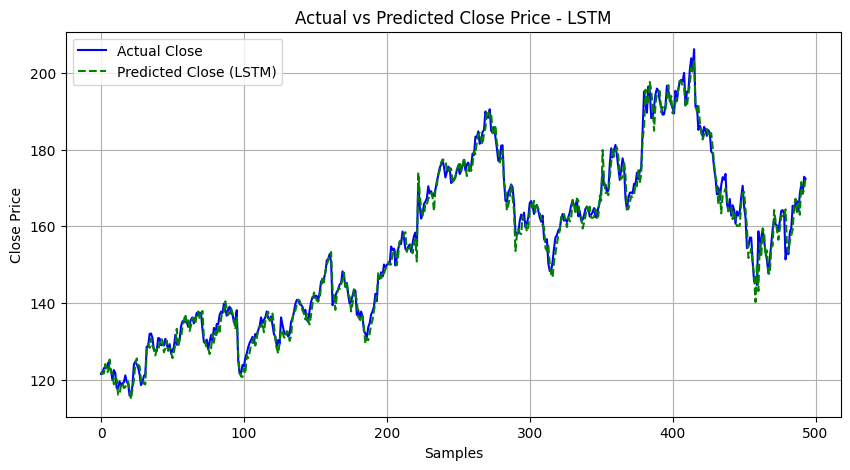

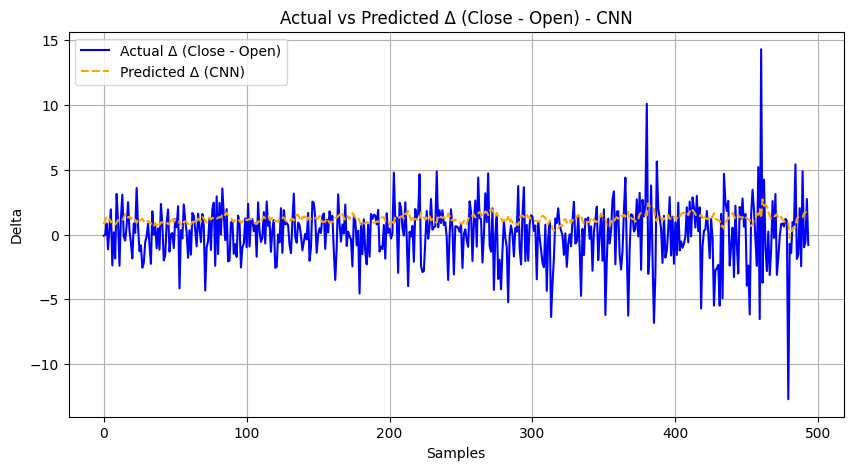

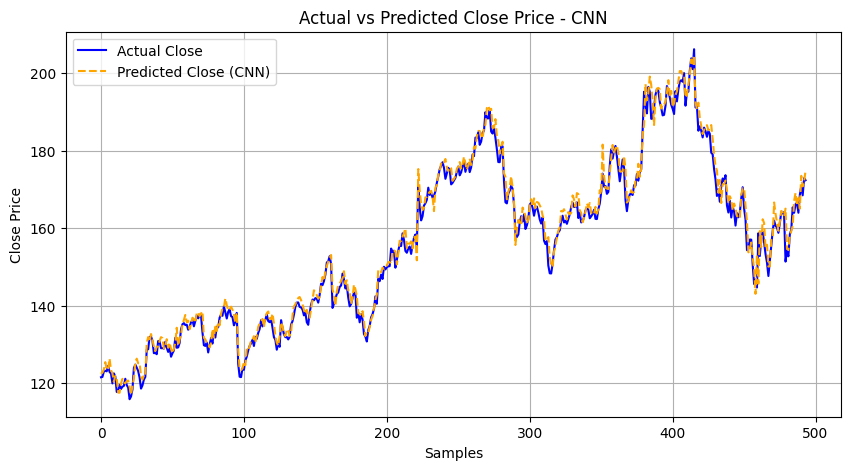

1/1 [==============================] - 0s 35ms/step
Running pipeline for META
           Close        RSI        EMAF        EMAM        EMAS    Target  \
0      94.673798  58.181973   93.150644   85.354341   81.803261 -2.050334   
1      93.857658  55.658632   93.217979   85.522724   81.962922 -1.074928   
2      93.708359  55.189492   93.264682   85.684815   82.118491 -1.522822   
3      93.180840  53.482911   93.256697   85.833252   82.265012 -0.109485   
4      93.748161  55.083326   93.303503   85.989982   82.417107  1.483016   
...          ...        ...         ...         ...         ...       ...   
2462  635.500000  61.133942  609.116233  597.037171  589.221318  3.710022   
2463  636.570007  61.393117  611.730878  597.819999  589.848452  2.520020   
2464  627.059998  57.727373  613.190794  598.399009  590.341321  3.059998   
2465  642.320007  61.662867  615.965005  599.268732  591.029780  6.910034   
2466  643.580017  61.976036  618.595006  600.146183  591.725810  0.980042  

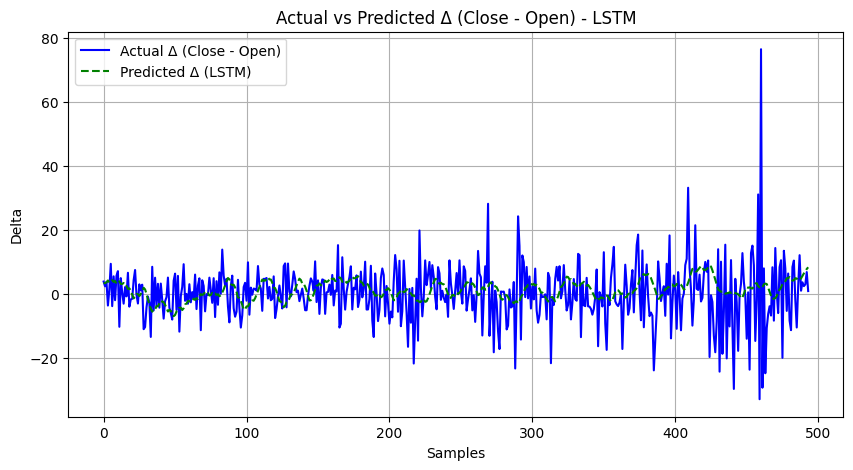

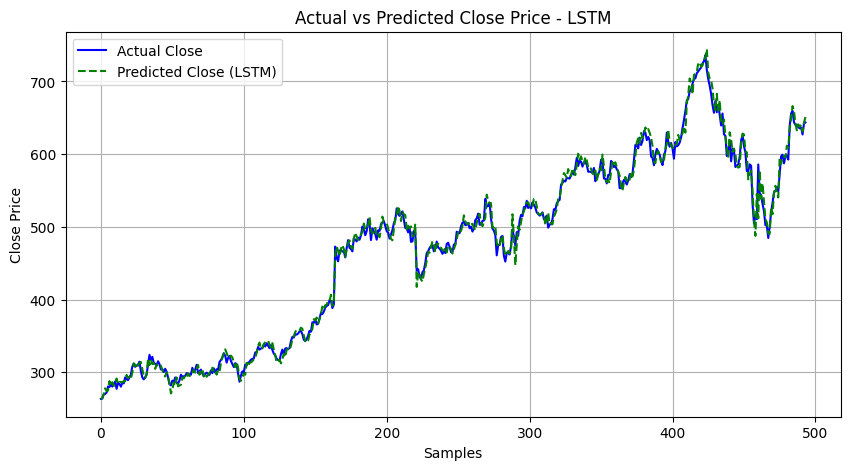

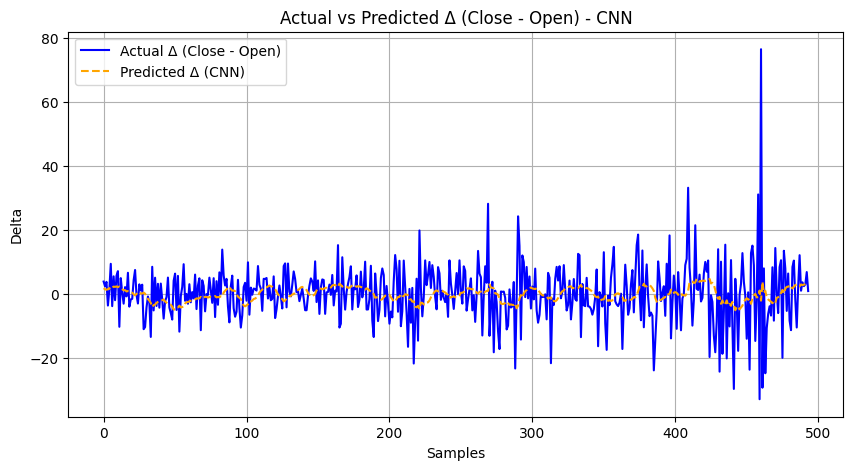

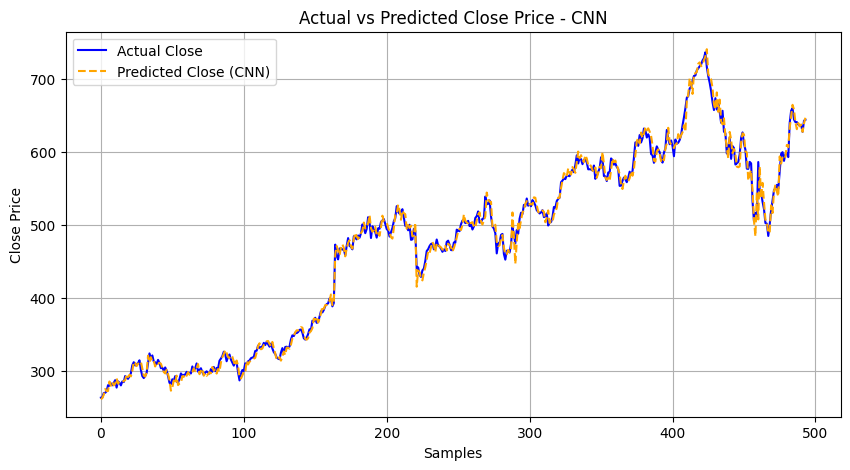

1/1 [==============================] - 0s 29ms/step
Running pipeline for TSLA
           Close        RSI        EMAF        EMAM        EMAS     Target  \
0      16.408667  40.237745   17.562829   16.245100   15.200760  -0.227333   
1      16.167334  38.598500   17.429924   16.243561   15.213562  -0.071333   
2      16.076000  37.971249   17.300979   16.240243   15.224985   0.199333   
3      15.824667  36.235112   17.160378   16.232013   15.232928   0.014667   
4      15.878000  36.891153   17.038247   16.225003   15.241472   0.211333   
...          ...        ...         ...         ...         ...        ...   
2462  334.619995  62.861937  310.176136  299.386162  296.815894  -9.809998   
2463  341.040009  64.591721  313.115552  300.210991  297.401643   9.140015   
2464  339.339996  63.749304  315.613118  300.985822  297.957118   1.419983   
2465  362.890015  69.628514  320.115680  302.211648  298.817157  15.540009   
2466  356.899994  66.681330  323.618948  303.294585  299.586466 

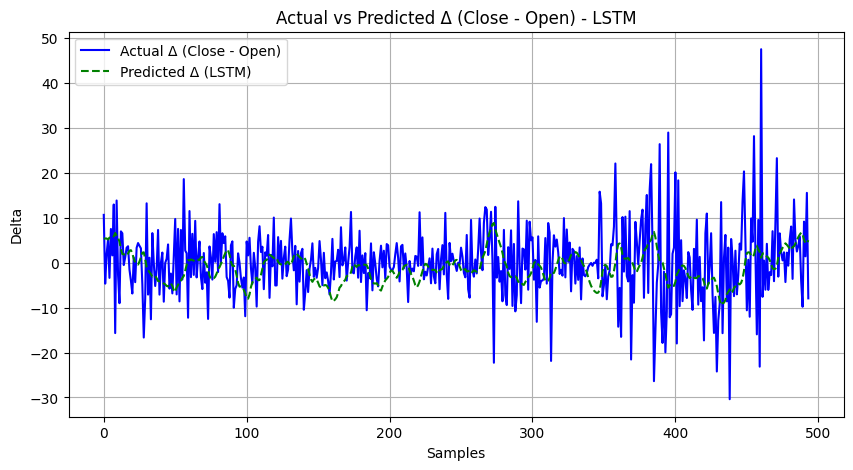

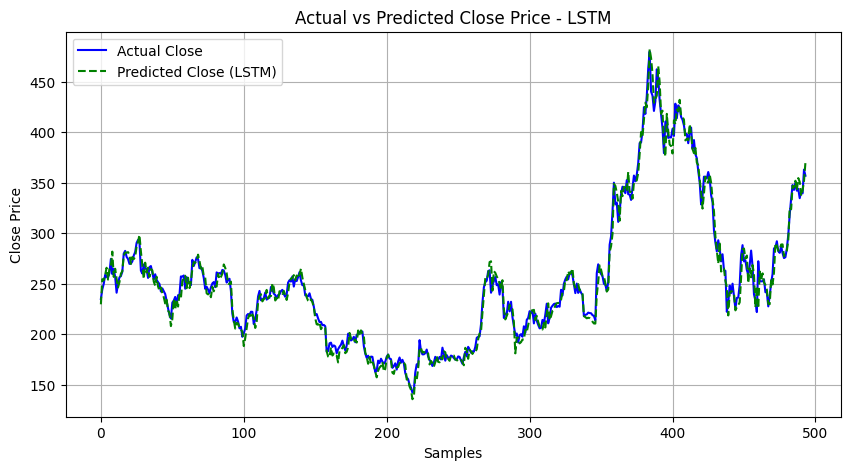

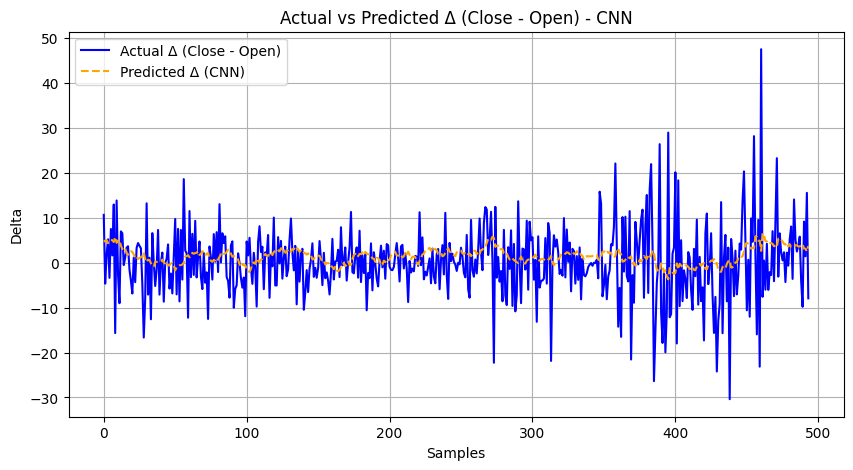

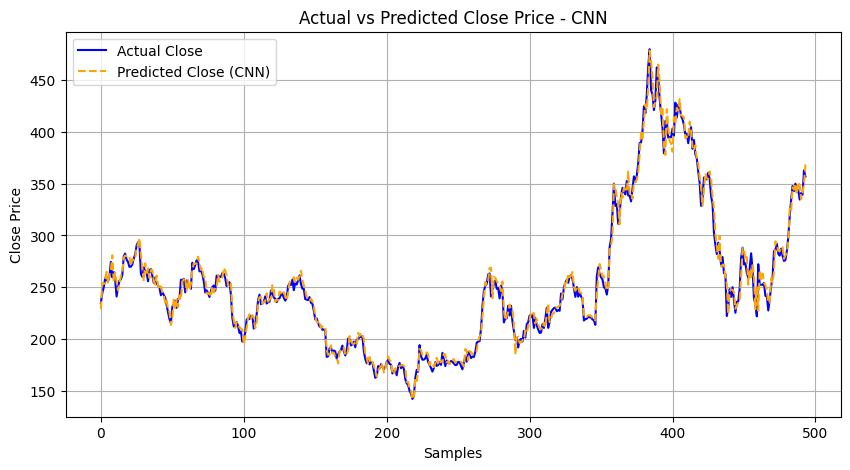

1/1 [==============================] - 0s 132ms/step
════════════════════════════════════════════════════
              🌟 **Investment Plan Summary** 🌟              
════════════════════════════════════════════════════

📈 **Stock**: GOOGL
   💼 **Buy** 2 shares on **Wednesday, May 28, 2025** at **$159.63**
   💸 **Sell** on **Friday, June 06, 2025** at **$171.65**
   ➡️ **Profit**: $24.05
---------------------------------------------------
📈 **Stock**: TSLA
   💼 **Buy** 29 shares on **Tuesday, June 03, 2025** at **$333.48**
   💸 **Sell** on **Friday, June 06, 2025** at **$365.0**
   ➡️ **Profit**: $914.26
---------------------------------------------------

════════════════════════════════════════════════════
💰 **Total Invested**: $9990.13
📊 **Total Expected Profit**: $938.31
════════════════════════════════════════════════════
4min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -n 1 -r 1
backcandles = int(input("Enter backcandles period in days (default: 45): ") or 45)
prediction_days = int(input("Enter prediction horizon in days (default: 10): ") or 10)
investment = int(input("Enter investment amount in dollars: "))

stocks = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "NVDA",  # NVIDIA Corporation
    "AMZN",  # Amazon.com, Inc.
    "GOOGL", # Alphabet Inc.
    "META",  # Meta Platforms, Inc.
    "TSLA",  # Tesla, Inc.
]
models = {}
predictions={}
for stock in stocks:
    trader = LSTMTrader(stock,backcandles,prediction_days)
    preds = trader.run_full_pipeline()
    predictions[stock]=preds
    models[stock] = trader

plan, invested, profit = optimize_trades_with_ilp(predictions, investment)

print("════════════════════════════════════════════════════")
print("              🌟 **Investment Plan Summary** 🌟              ")
print("════════════════════════════════════════════════════\n")

# Loop through each plan
for p in plan:
    buy_date = get_exact_date(p['buy_day'])
    sell_date = get_exact_date(p['sell_day'])

    print(f"📈 **Stock**: {p['stock']}")
    print(f"   💼 **Buy** {p['shares']} shares on **{buy_date}** at **${p['buy_price']}**")
    print(f"   💸 **Sell** on **{sell_date}** at **${p['sell_price']}**")
    print(f"   ➡️ **Profit**: ${p['profit']}")
    print("---------------------------------------------------")

# Displaying Total Invested and Profit with a modern summary format
print("\n════════════════════════════════════════════════════")
print(f"💰 **Total Invested**: ${invested}")
print(f"📊 **Total Expected Profit**: ${profit}")
print("════════════════════════════════════════════════════")